# Import

In [1]:
!pip install nltk gensim spacy
!pip install keyBERT
!pip install pyLDAvis
!python -m spacy download en_core_web_sm


# Import necessary libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from collections import Counter, defaultdict
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, silhouette_samples


import gensim.downloader as api
from gensim.models import FastText
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import spacy
import string
import torch

from keybert import KeyBERT
from transformers import BartModel, BartTokenizer, pipeline
from sentence_transformers import SentenceTransformer

# Download a spaCy language model (e.g., English)

nlp = spacy.load('en_core_web_sm')
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages

# Read data

In [124]:
df = pd.read_csv('/content/sample_data/claims_text.csv')

# EDA - Basic statistics

In [125]:
df.head(3)

,text
0,CLAIMS1. A wireless telephone apparatus compri...
1,"The apparatus of claim, ftirther comprising a ..."
2,"The apparatus of claim, 2 or 3, ftirther compr..."


### Util functions

In [126]:
def preprocess_text(text):
    # Preprocess text: remove stop words, punctuation, and tokenize
    stop_words = set(stopwords.words('english'))
    punctuation_table = str.maketrans('', '', string.punctuation)
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(punctuation_table)

    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    return words

def find_best_splitter(doc):
  splitters = ['.', ';', ',']
  for sp in splitters:
      sentences = doc.split(sp)
      sentence_lengths = [len(nltk.word_tokenize(sentence)) for sentence in sentences]
      if len(sentences) > 1 and all(length > 10 for length in sentence_lengths):
          print("chosen spliter", sp, len(sentences))
          return sp
  return None

# Function to split long documents into two balanced parts by splitting on the dot
def split_long_document(doc, word_threshold=80):
    words = nltk.word_tokenize(doc)
    if len(words) < word_threshold:
        return [doc], None

    splitter = find_best_splitter(doc)
    if splitter:
        sentences = doc.split(splitter)
        min_length = 50 if len(words) * 0.4 > 50 else len(words) * 0.4

        # Initialize two empty parts
        doc_1, doc_2 = "", ""

        # Distribute sentences between two parts, keeping word counts balanced
        for sentence in sentences:
            if len(nltk.word_tokenize(doc_1)) < min_length:
                doc_1 += sentence + splitter
            else:
                doc_2 += sentence + splitter

        if len(nltk.word_tokenize(doc_1)) >= min_length and len(nltk.word_tokenize(doc_2)) >= min_length:
            return doc_1.strip(), doc_2.strip()

    return [doc], None


# Apply the split and track IDs
def split_documents(df, word_threshold=80):
    new_data = []

    for idx, row in df.iterrows():
        doc_1, doc_2 = split_long_document(row['text'], word_threshold)

        # If doc_1 is split into two parts, add both parts to the DataFrame
        if doc_2:
            new_data.append({'text': doc_1, 'claim_id': f"{row['claim_id']}_1"})
            new_data.append({'text': doc_2, 'claim_id': f"{row['claim_id']}_2"})
        else:
            new_data.append({'text': doc_1[0], 'claim_id': row['claim_id']})

    return pd.DataFrame(new_data)

df['processed_text'] = df['text'].apply(preprocess_text)
df['processed_text'] = df['processed_text'].apply(' '.join)

### Distriubtions

Looking at the disributions of the words, doc length and unique word we can easily identify to types of docs - short claims and long claims. This behavior may indicates that claim could serve two different purpose. It would probabily affects the clustering steps, also on the topic selections. To prevent larger documents from dominating the clusters or topics, longer document need to be splitted. According to these graphs, 80 words is a godd splits.




In [127]:
# Calculate basic statistics for each document
word_count = df['processed_text'].apply(lambda x: len(nltk.word_tokenize(x)))  # Word count
char_count = df['processed_text'].apply(len)  # Character count
unique_word_count = df['processed_text'].apply(lambda x: len(set(nltk.word_tokenize(x))))  # Unique word count

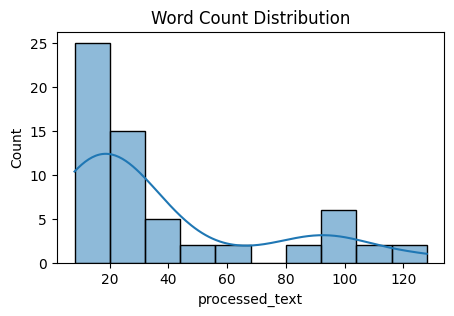

8 128


In [128]:
# 1. Word Count Distribution
plt.figure(figsize=(5, 3))
sns.histplot(word_count, bins=10, kde=True)
plt.title('Word Count Distribution')
plt.show()

print(min(word_count), max(word_count))

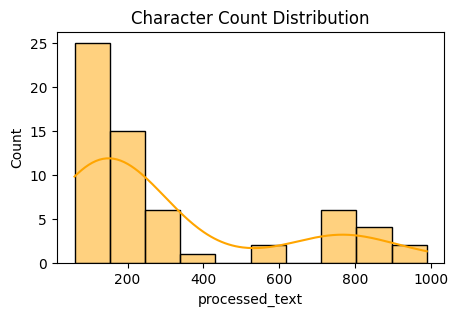

60 990


In [129]:
# 2. Character Count Distribution
plt.figure(figsize=(5, 3))
sns.histplot(char_count, bins=10, kde=True, color='orange')
plt.title('Character Count Distribution')
plt.show()
print(min(char_count), max(char_count))


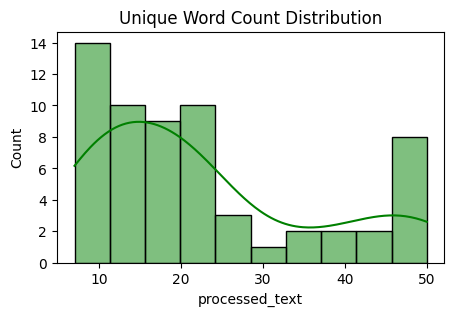

In [130]:
# 3. Unique Word Count Distribution
plt.figure(figsize=(5, 3))
sns.histplot(unique_word_count, bins=10, kde=True, color='green')
plt.title('Unique Word Count Distribution')
plt.show()


### Word analysis

Lerning the terminology is a good approcas to interprate later better the results. For instance, 'jitter' and 'packet' are two words that seems to reflect well the mobile comunication words. On the other hand, 'wherein' and 'said' reflect much the patent claim terminology.

Moreover, we can appreciate in the word cloud more words like waveform, and signal, that gives us an intuition of what topics to choose.

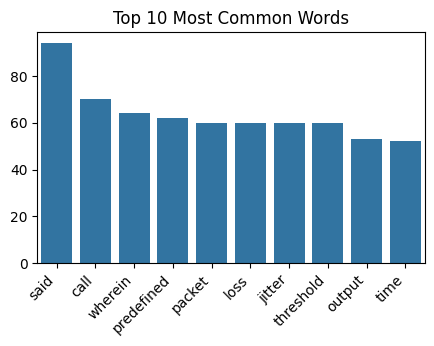

In [131]:
# 4. Word Frequency
plt.figure(figsize=(5, 3))
all_words = ' '.join(df['processed_text'])
word_freq = Counter(nltk.word_tokenize(all_words))
most_common_words = word_freq.most_common(10)
words, counts = zip(*most_common_words)

sns.barplot(x=list(words), y=list(counts))
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()


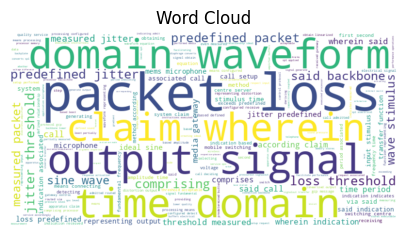

In [132]:
# 5. Word Cloud
plt.figure(figsize=(5, 3))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

### Long text split

In [133]:
df['claim_id'] = df.index + 1  # Use index+1 as unique claim IDs

# Execute the function on your DataFrame
df = split_documents(df.copy())


chosen spliter ; 3
chosen spliter ; 4
chosen spliter ; 4
chosen spliter ; 3
chosen spliter ; 3
chosen spliter , 4
chosen spliter , 4
chosen spliter ; 4
chosen spliter ; 4
chosen spliter ; 2
chosen spliter ; 4
chosen spliter ; 4
chosen spliter ; 3
chosen spliter ; 3


In [134]:
df.head()

,text,claim_id
0,CLAIMS1. A wireless telephone apparatus compri...,1
1,"The apparatus of claim, ftirther comprising a ...",2
2,"The apparatus of claim, 2 or 3, ftirther compr...",3_1
3,and transfer means for putting the first call ...,3_2
4,"The apparatus of claim, wherein the first pred...",4


# Method 1 -

The idea behind this approach is to treat the data like a "treasure hunt" that needs to be decoded by uncovering hidden connections. Once these connections are identified and mapped, we can group similar claims and extract the common topics.

The process includes:

* Text preprocessing
* Text to vector transformation using TF-IDF: This is a simple yet efficient vectorization method that leverages word frequencies within sentences and across the entire corpus. Setting word frequencies as a connection metric helps identify similarities. The assumption here is that paragraphs are similar based on the significance or insignificance of words.
* Clustering using Kmeans and hypertuning
* Topic extraction
* Model Evaluation


#### The Clustering Challenge:
Several clustering methods are available, each with its own pros and cons. Kmeans was selected for its ability to effectively cluster multidimensional data using density and distance metrics. K-means does not natively support cosine similarity because it relies on Euclidean distance for cluster assignment and centroid calculation. However, you can still use cosine similarity for clustering, but it requires some transformations. Additionally, a user can easily plug in a number of group they want the model to cluster. Also, it is works well on small medium data. The main drawback of KMEAN is not working well with non linear data and on very large dataset

#### Model Parameters:
The Elbow Method helps determine the optimal number of clusters in K-means by plotting the sum of squared distances against different values of k. The "elbow" point, where the rate of decrease in inertia slows significantly, indicates the optimal number of clusters as adding more clusters beyond this point doesn't significantly improve the model.

To choose the parameter k, look for the point where the curve bends sharply (the "elbow"), as this indicates the most appropriate number of clusters that balances simplicity and effectiveness.


## Utils function

In [135]:
def preprocess_text(text):
    # This function processes the input text by removing punctuation, converting to lowercase,
    # tokenizing the text, and removing stopwords. It returns the cleaned text.

    # Define a set of stopwords, including additional custom words
    stop_words = set(stopwords.words('english'))
    stop_words.update(['claim', 'claims', 'claims1', 'first', 'second', 'said'])

    # Remove punctuation
    punctuation_table = str.maketrans('', '', string.punctuation)
    text = text.lower()  # Convert text to lowercase
    text = text.translate(punctuation_table)  # Remove punctuation

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stopwords from the tokenized words
    words = [word for word in words if word not in stop_words]

    # Return the processed text as a single string
    return ' '.join(words)


def extract_top_keywords_per_cluster(X, clusters, num_keywords=2):
    # Store the top keywords for each cluster
    cluster_keywords = {}

    # Loop over each unique cluster
    for cluster_num in np.unique(clusters):
        # Ignore noise points (-1)
        if cluster_num == -1:
            continue

        # Filter documents belonging to the current cluster
        cluster_docs = X[clusters == cluster_num]

        # Calculate the mean TF-IDF score for the cluster
        mean_tfidf = cluster_docs.mean(axis=0).A1

        # Identify top keyword indices based on highest mean TF-IDF scores
        top_indices = mean_tfidf.argsort()[-num_keywords:][::-1]

        # Extract the corresponding keywords
        top_keywords = [vectorizer.get_feature_names_out()[i] for i in top_indices]
        cluster_keywords[cluster_num] = ' '.join(top_keywords)

    return cluster_keywords

def analyze_td_idf(X):# Get feature out
  # feature_names = vectorizer.get_feature_names_out()
  # print(feature_names)

  binary_matrix = (X > 0).astype(int)
  # Sum across the rows (axis=0) to get the document frequency of each term
  doc_frequencies = binary_matrix.sum(axis=0).A1  # .A1 converts the sparse matrix to a 1D array

  # Plot the document frequency distribution
  plt.figure(figsize=(6, 4))
  plt.hist(doc_frequencies, bins=15)
  plt.title("Document Frequency Distribution")
  plt.xlabel("Document Frequency (Number of Documents)")
  plt.ylabel("Number of Terms")
  plt.show()

  # Calculate the mean document frequency
  mean_doc_frequency = doc_frequencies.mean()
  print(f"Mean document frequency: {mean_doc_frequency}")

  # Check the sparsity of the TF-IDF matrix
  sparsity = (X.nnz / float(X.shape[0] * X.shape[1])) * 100
  print(f"Sparsity: {sparsity:.2f}%")

  tfidf_values = X.data

  # Plot the distribution of TF-IDF values to assess variability
  plt.figure(figsize=(6, 4))
  plt.hist(tfidf_values, bins=30, color='skyblue', edgecolor='black')
  plt.title("TF-IDF Value Distribution")
  plt.xlabel("TF-IDF Value")
  plt.ylabel("Frequency")
  plt.show()

  # Calculate basic statistics of the TF-IDF values for analysis
  mean_tfidf = np.mean(tfidf_values)
  std_tfidf = np.std(tfidf_values)
  min_tfidf = np.min(tfidf_values)
  max_tfidf = np.max(tfidf_values)

  print(f"Mean TF-IDF: {mean_tfidf}")
  print(f"Standard Deviation of TF-IDF: {std_tfidf}")
  print(f"Min TF-IDF: {min_tfidf}")
  print(f"Max TF-IDF: {max_tfidf}")

def calc_silhouette_score(X, labels, cluster_col_name):

  # Compute the silhouette scores for each sample
  silhouette_vals = silhouette_samples(X, labels)

  # Compute the number of clusters
  cluster_labels = np.unique(labels)

  # Set up the plot
  y_lower = 10
  fig, ax1 = plt.subplots(figsize=(7, 4))

  # Loop over each cluster and plot the silhouette scores
  for i, cluster in enumerate(cluster_labels):
      # Aggregate silhouette scores for samples in the current cluster
      cluster_silhouette_vals = silhouette_vals[labels == cluster]
      cluster_silhouette_vals.sort()

      y_upper = y_lower + len(cluster_silhouette_vals)
      color = plt.cm.Spectral(float(i) / len(cluster_labels))

      ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
      ax1.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(cluster))

      y_lower = y_upper + 10  # Add space between silhouette plots for different clusters

  silhouette_avg = silhouette_score(X, df_[cluster_col_name].values)

  # Add labels and title
  ax1.set_title("Silhouette Plot for KMEANS Clustering")
  ax1.set_xlabel("Silhouette Coefficient")
  ax1.set_ylabel("Cluster Label")
  ax1.axvline(x=np.round(silhouette_avg, 3), color="red", linestyle="--")  # Mark the average silhouette score
  plt.show()


  print(f'Silhouette Score: {silhouette_avg}')


## Main


### Preprocess - vectorize the claims

We will begin by setting up the appropriate TF-IDF model. First, we’ll train a near-parameterless model, analyze the results, and adjust it accordingly.

To fine-tune parameters like max_df, min_df, and smoothing or dimensionality reduction, we will use several analysis tools to guide our decisions.

When examining the term frequency distribution, we gain two important insights:

Looking at the term frequncy distribution helps to understand two points:
1. Most terms appear in very few documents: This suggests that many terms are unique or rare, indicating that the documents may be distinct and cover a wide range of topics or technical details.
2. A few terms appear in a large number of documents: These terms, being limited in number, likely represent common, domain-specific terms rather than generic stopwords.

Given the high sparsity of the data, reducing the vocabulary size may not be ideal. High sparsity means that many words do not appear across other documents. In our case, where we aim to group documents and assign topics, having too many unique documents could result in too many clusters and overly diverse topics. The current level of sparsity indicates a healthy amount of unique terms.

Finally, smoothing may not be necessary, as the distribution appears to have good kurtosis. However, high frequencies of certain TF-IDF values could indicate noise in the data, and in such cases, applying smoothing could help reduce the noise.





chosen spliter , 5
chosen spliter , 5
chosen spliter ; 3
chosen spliter ; 3
chosen spliter , 4
chosen spliter , 4
chosen spliter ; 2


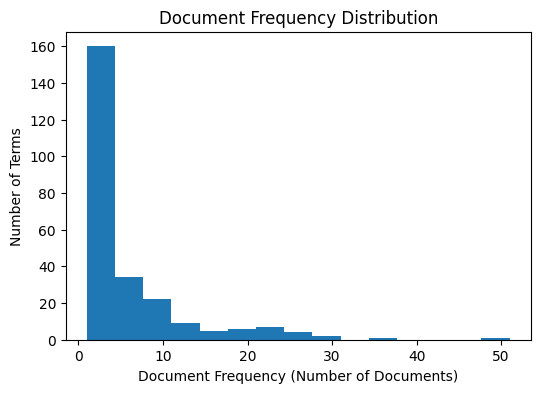

Mean document frequency: 5.7848605577689245
Sparsity: 7.42%


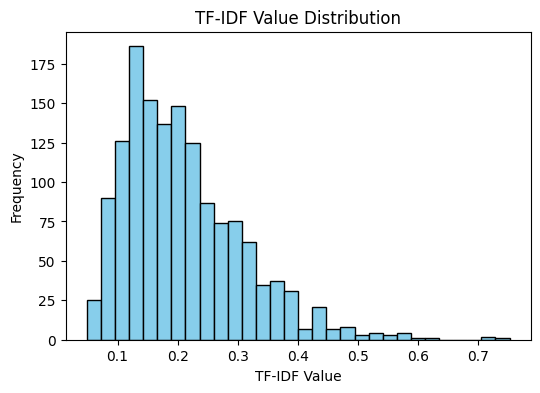

Mean TF-IDF: 0.20947312412224936
Standard Deviation of TF-IDF: 0.09919686756610573
Min TF-IDF: 0.04874633925423735
Max TF-IDF: 0.7524633798053721


In [136]:
df_ = split_documents(df.copy())
df_['processed_text'] = df_['text'].apply(preprocess_text)
df_ = df_.sample(frac=1)

# Adjust the TFiDF model parameters - start with not ristrictive model
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_['processed_text'])
analyze_td_idf(X)


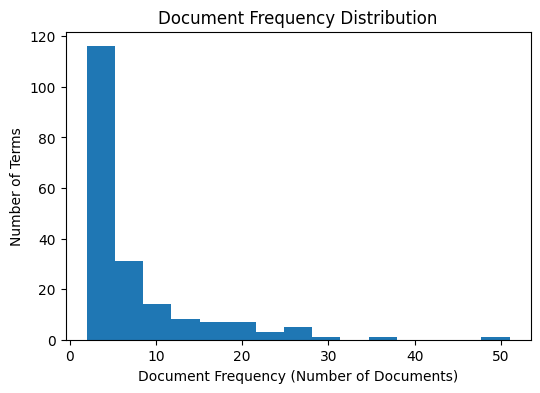

Mean document frequency: 7.190721649484536
Sparsity: 9.22%


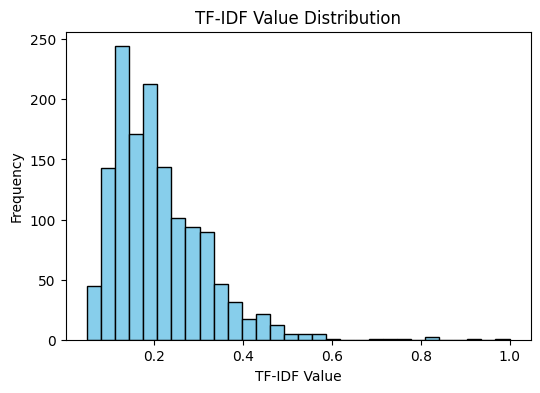

Mean TF-IDF: 0.21121297496391508
Standard Deviation of TF-IDF: 0.10631583937267404
Min TF-IDF: 0.04874633925423735
Max TF-IDF: 1.0


In [137]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(min_df=0.015)
X = vectorizer.fit_transform(df_['processed_text'])
analyze_td_idf(X)

### Clustering and hyperparmeter tuning



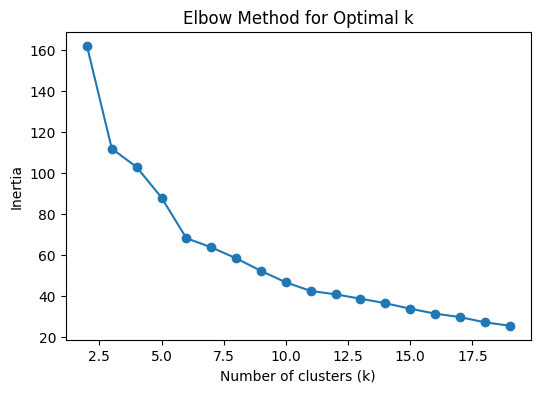

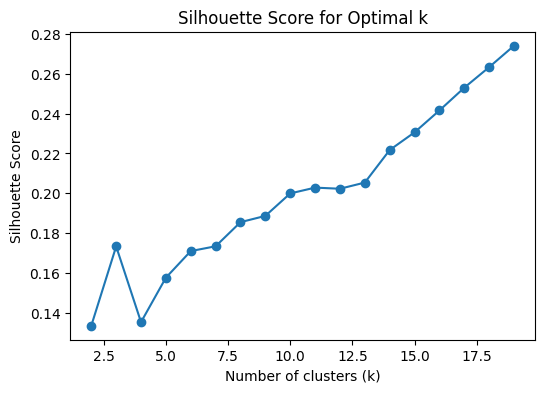

In [138]:
cosine_similarities = cosine_similarity(X)

inertia = []
silhouette_avg_list = []
for k in range(2, 20):  # Test values of k from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cosine_similarities)
    inertia.append(kmeans.inertia_)

    # Calculate the average silhouette score for the current value of k
    if k > 1:
      cluster_labels = kmeans.labels_
      silhouette_avg = silhouette_score(X, cluster_labels)
      silhouette_avg_list.append(silhouette_avg)


# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(range(2, 20), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


# Plot the silhouette score curve
plt.figure(figsize=(6, 4))
plt.plot(range(2, 20), silhouette_avg_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


### Train and predict

In [139]:
# Apply Kmean, k=8 clustering
kmean_model = KMeans(n_clusters=8, random_state=42)
kmean_model.fit(cosine_similarities)
clusters = kmean_model.predict(cosine_similarities)
clusters



array([4, 3, 3, 7, 7, 7, 1, 5, 1, 1, 1, 6, 1, 4, 6, 2, 4, 2, 7, 3, 1, 3,
       6, 2, 0, 7, 1, 0, 3, 0, 4, 5, 5, 1, 3, 4, 4, 1, 2, 1, 3, 0, 7, 2,
       1, 7, 2, 1, 2, 1, 3, 1, 2, 7, 0, 2, 7, 4, 2, 4, 4, 4, 3, 4, 0, 5,
       0, 2, 3, 0, 2, 2, 7, 3, 2, 2, 0, 3], dtype=int32)

In [140]:
df_['cluster'] = clusters

### Evaluation

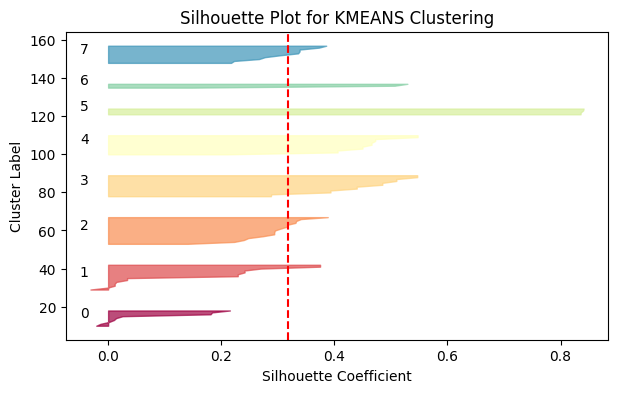

Silhouette Score: 0.31766654917028386


In [141]:
labels = df_['cluster'].values
calc_silhouette_score(cosine_similarities, labels, 'cluster')

In [142]:
# We can see how the splitted sentences where clustered the same, so we would merge them back
def get_doubled_id(x):
  if isinstance(x, str):
    if '_' in x:
      return True
    return False
  return False

splited_claim_df = df_[df_['claim_id'].apply(get_doubled_id)]
splited_claim_df[['claim_id', 'cluster']].sort_values(by='claim_id').T

,15,16,17,18,26,27,28,29,33,34,...,2,3,62,63,64,65,70,71,72,73
claim_id,15_1,15_2,16_1,16_2,24_1,24_2,25_1,25_2,29_1,29_2_1,...,3_1,3_2,50_1,50_2,51_1,51_2,56_1,56_2,57_1,57_2
cluster,1,3,1,3,1,3,1,3,1,3,...,2,2,4,4,4,4,4,4,4,4


In [143]:
# Get the top keywords for each cluster
cluster_keywords = extract_top_keywords_per_cluster(X, df_['cluster'].values, num_keywords=3)
cluster_keywords[-1] = 'others'

# Display the results
for cluster_num, keywords in cluster_keywords.items():
    print(f"Cluster {cluster_num}: Top Keywords: {keywords}")
    print("Number of sentences in this cluster:", df_[df_['cluster'] == cluster_num]['text'].shape[0])
    print("------\n")

Cluster 0: Top Keywords: output voltage waveform
Number of sentences in this cluster: 9
------

Cluster 1: Top Keywords: packet jitter loss
Number of sentences in this cluster: 14
------

Cluster 2: Top Keywords: apparatus button call
Number of sentences in this cluster: 15
------

Cluster 3: Top Keywords: predefined threshold packet
Number of sentences in this cluster: 12
------

Cluster 4: Top Keywords: stimulus output representing
Number of sentences in this cluster: 11
------

Cluster 5: Top Keywords: diaphragm electrical signal
Number of sentences in this cluster: 4
------

Cluster 6: Top Keywords: distortion system wherein
Number of sentences in this cluster: 3
------

Cluster 7: Top Keywords: according source method
Number of sentences in this cluster: 10
------

Cluster -1: Top Keywords: others
Number of sentences in this cluster: 0
------



In [144]:
df_['topic'] = list(map(lambda x: cluster_keywords[x], df_['cluster']))
df_['topic'][35:41]

,topic
62,stimulus output representing
64,stimulus output representing
26,packet jitter loss
7,apparatus button call
45,packet jitter loss
46,predefined threshold packet


# Method 2 -

In this approach, topic generation and text clustering are integrated and enhanced with the power of large language models (LLMs).

The initial step involves sending a claim and a task to a selected LLM. The task is to extract keywords, which serve as a type of topic. The process is structured in two iterations:


* **First iteration**: Squeezing the text by generating many distinct short topics.

* **Second iteration**: A common ground is established by concatenating the topics generated in the first iteration into one string, separated by commas. The LLM receives this new string and is tasked with generating 2 to 4 keywords. This final list of topics is based on the model's top K results.

Next, both the claims and topics are embedded, and cosine similarity is applied across all claims and topics. The claim with the highest similarity to a topic is assigned to that topic, forming a cluster.

If the maximum similarity score doesn't meet a specified threshold, the claim is assigned to an "Other" category.

#### Downsides and advantages
The use of large models impacts memory and latency. Also, the process involves multiple steps. However, the advantage of this approach is that the topics are more descriptive, and the embedding transformation leads to more accurate clustering results.

## Util functions


In [145]:

def generate_topics_from_sentences(document, ngram_range, top_n=3):
    # Function to generate topics using a prompt-based approach

    # Use KeyBERT to extract keywords (topics) from the document
    result = kw_model.extract_keywords(document, keyphrase_ngram_range=ngram_range, stop_words='english', top_n=top_n)
    return result

def generate_topics_with_qna(q, document):
    # Get the answer from the document
    result = qa_pipeline(question=q, context=document)
    return result['answer']


# Step 2: Embed documents using SBERT
def embed_doc(text):
    # SBERT model to generate embeddings for a document
    embeddings = sbert_model.encode(text, convert_to_tensor=True)
    return embeddings


def cosine_similarity_matrix(claim_docs_embed, final_topic_dict):
    # Function to calculate a cosine similarity matrix between claim documents and topics

    # Initialize an empty cosine similarity matrix
    cosine_sim_matrix = torch.zeros(len(claim_docs_embed), len(final_topic_dict))

    # Calculate cosine similarity between each claim document and each topic embedding
    for i, claim_doc in enumerate(claim_docs_embed):
        for j, final_doc in enumerate(final_topic_dict.values()):

             # Ensure both embeddings have the same shape: [1, 384]
            if claim_doc.dim() == 1:
                claim_doc = claim_doc.unsqueeze(0)
            if final_doc.dim() == 1:
                final_doc = final_doc.unsqueeze(0)

            # Compute cosine similarity
            cosine_sim_matrix[i, j] = torch.cosine_similarity(claim_doc, final_doc)


    # Convert the cosine similarity matrix to a NumPy array for easier handling
    cosine_sim_matrix = cosine_sim_matrix.numpy()

    return cosine_sim_matrix


## Main

In [146]:
qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")
kw_model = KeyBERT(model='distilbert-base-nli-mean-tokens')
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

### Topic generation

In [147]:
df_ = split_documents(df.copy())
df_ = df_.sample(frac=1)

df_['processed_text'] = df_['text'].apply(preprocess_text)

# Generate an estimate 2 words topic
df_['topic_1'] = df_['processed_text'].apply(lambda x: generate_topics_with_qna(q = 'What is the topic of the following text?', document=x))

print("count how many unique topics", df_['topic_1'].nunique())

concat_topic_size_2 = ', '.join(df_['topic_1'])

chosen spliter , 5
chosen spliter , 5
chosen spliter ; 3
chosen spliter ; 3
chosen spliter , 4
chosen spliter , 4
chosen spliter ; 2
count how many unique topics 50


In [148]:
# Generate new possible topics, out of the previous stacked couple topic, and retrieve n top topic with size 2 to 4
topic_df_s_5 = {}

for i in range(1,5):
  new_topics = generate_topics_from_sentences(concat_topic_size_2, ngram_range = (i,i+1), top_n = 5)
  new_topics = [ i[0] for i in new_topics]
  field_name = f'topic_{i+1}'
  topic_df_s_5[field_name] = new_topics

pd.DataFrame(topic_df_s_5)

,topic_2,topic_3,topic_4,topic_5
0,domain waveform,waveform gcp message,waveform gcp message context,output data time domain waveform
1,gateway microelectromechanical,context request deriving,data time domain waveform,wave stimulus time domain waveform
2,waveform gcp,domain waveform gcp,wave stimulus time domain,domain waveform representing output signal
3,gateway packet,method media gateway,stimulus time domain waveform,time domain waveform gcp message
4,signal processing,time domain waveform,domain waveform explicit transfer,data time domain waveform representing


In [149]:
topic_df_s_8 = {}

for i in range(1,5):
  new_topics = generate_topics_from_sentences(concat_topic_size_2, ngram_range = (i,i+1), top_n = 8)
  new_topics = [ i[0] for i in new_topics]
  field_name = f'topic_{i+1}'
  topic_df_s_8[field_name] = new_topics

pd.DataFrame(topic_df_s_8)

,topic_2,topic_3,topic_4,topic_5
0,domain waveform,waveform gcp message,waveform gcp message context,output data time domain waveform
1,gateway microelectromechanical,context request deriving,data time domain waveform,wave stimulus time domain waveform
2,waveform gcp,domain waveform gcp,wave stimulus time domain,domain waveform representing output signal
3,gateway packet,method media gateway,stimulus time domain waveform,time domain waveform gcp message
4,signal processing,time domain waveform,domain waveform explicit transfer,data time domain waveform representing
5,gateway transfer,media gateway microelectromechanical,processor sine wave stimulus,waveform gcp message context request
6,gateway initiation,processor sine wave,signal output voltage packet,signal voltage output measured packet
7,signal output,media gateway initiation,domain waveform gcp message,importing output data time domain


### Topic - claim similarity

In [150]:
# Transform each claim into its numerical representation
final_topic_dict = {doc: embed_doc(doc) for doc in topic_df_s_5['topic_4']}

# Transform each topic into its numerical representation
claim_docs_embed =  df_['processed_text'].apply(lambda x: embed_doc(x))

# Map index topic
topic_index_map = {str(i): topic for i, topic in enumerate(final_topic_dict.keys())}


In [151]:
# calculate cosine similarity between a claim and a topic
cosine_sim_matrix = cosine_similarity_matrix(claim_docs_embed, final_topic_dict)

# Use the argmax to get the best similrity score index, and map back the topic
df_['cluster'] = list(
                map(
                    lambda doc_similarity_vec:
                      topic_index_map[
                          str(
                            np.argmax(
                              doc_similarity_vec
                              )
                            )
                      ],
                      cosine_sim_matrix
                    )
                )

In [152]:
df_.head(6)

,text,claim_id,processed_text,topic_1,cluster
52,"A system, comprising:\na processor; and\na mem...",40,system comprising processor memory stores exec...,performance operations,stimulus time domain waveform
23,"The method according to claim, wherein said in...",21,method according wherein indication received i...,method according wherein indication received i...,stimulus time domain waveform
61,"The system of claim, wherein the distortion is...",49,system wherein distortion frequency dependent ...,distortion frequency dependent,data time domain waveform
55,"The system of claim, wherein the obtaining com...",43,system wherein obtaining comprises importing o...,importing output data time domain waveform rep...,data time domain waveform
73,"selecting, by the system based on a defined re...",57_2,selecting system based defined relationship si...,selecting system based defined relationship si...,stimulus time domain waveform
56,"The system of claim, wherein the defined relat...",44,system wherein defined relationship represents...,voltage difference ideal sine wave stimulus ti...,stimulus time domain waveform


In [153]:
df_['text'][75]

'The method of claim, wherein the output signal is a voltage output, and wherein the selecting comprises:\nmeasuring, by the system, the voltage output.'

### Evaluation

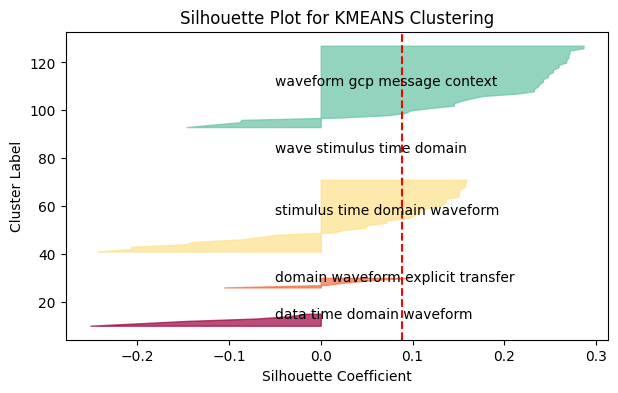

Silhouette Score: 0.08820801228284836


In [156]:
claim_docs_embed_numpy = np.vstack(claim_docs_embed.apply(lambda x: x.numpy()).to_list())
labels = df_['cluster'].values
calc_silhouette_score(claim_docs_embed_numpy, labels, 'cluster')

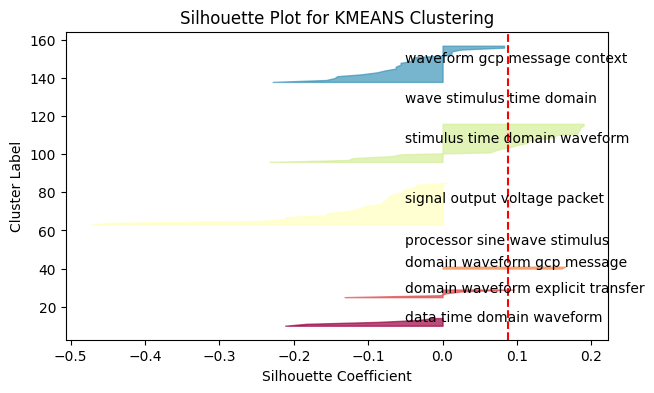

Silhouette Score: 0.08820801228284836


In [157]:
# Transform each claim into its numerical representation
final_topic_dict = {doc: embed_doc(doc) for doc in topic_df_s_8['topic_4']}
# Map index topic
topic_index_map = {str(i): topic for i, topic in enumerate(final_topic_dict.keys())}
# calculate cosine similarity between a claim and a topic
cosine_sim_matrix = cosine_similarity_matrix(claim_docs_embed, final_topic_dict)

# Use the argmax to get the best similrity score index, and map back the topic
cluster_8 = list(
                map(
                    lambda doc_similarity_vec:
                      topic_index_map[
                          str(
                            np.argmax(
                              doc_similarity_vec
                              )
                            )
                      ],
                      cosine_sim_matrix
                    )
                )
claim_docs_embed_numpy = np.vstack(claim_docs_embed.apply(lambda x: x.numpy()).to_list())
cluster_8 = np.array(cluster_8)
calc_silhouette_score(claim_docs_embed_numpy, np.array(cluster_8), 'cluster')

# Method 3 -

This method uses Latent Dirichlet Allocation (LDA) for topic modeling and clustering. Like TF-IDF, LDA relies on word frequencies, but instead of focusing on document-level importance, LDA uncovers hidden topics by modeling how words are distributed across documents. Each document is viewed as a mixture of topics, and the most likely topic is assigned to it.

LDA integrates topic generation and clustering, similar to the LLM approach, but with key differences:

* No LLM required: LDA is a probabilistic model, making it computationally lightweight.
*Frequencies vs. Context: LDA, like TF-IDF, depends on word frequencies and doesn’t understand semantics or context like LLMs.

LDA lacks contextual understanding like LLMs, requires the user to predefine the number of topics, and can produce overlapping topics, which may lead to unclear distinctions between clusters.Nevertheless, LDA is ideal when you need a fast, interpretable model for topic extraction and clustering. However, for more nuanced text analysis, LLMs may provide better context and precision

#### Process step
1. reprocessing - The text is cleaned by removing punctuation, converting to lowercase, and removing stopwords. This results in the processed_text column.
2. Modeling - The documents are tokenized and converted into a bag-of-words. Then, an LDA model is applied to extract 6 topics from the corpus.
3. Topic Assignment - Each document is assigned a dominant topic based on its highest probability from the LDA model. If the topic probability is below a threshold, the document is labeled as 'Other'.
4. Visualization & Topic Generation - The top 3 words for each topic are printed, and summaries are generated for each topic, which are then mapped back to the original documents for easy interpretation.

## Util functions

In [116]:
def get_dominant_topic(lda_model, bow_doc, threshold=0.9):
    # This function extracts the dominant topic from the LDA model for a given document.
    # If the probability of the dominant topic is below the threshold, it assigns the document to 'Other'.

    # Get the topic distribution for the document
    topic_distribution = lda_model.get_document_topics(bow_doc)

    # Find the topic with the highest probability
    dominant_topic, max_prob = max(topic_distribution, key=lambda item: item[1])

    # Check if the highest probability is below the given threshold
    if max_prob < threshold:
        return 'Other'  # Assign the 'Other' topic if below threshold

    return dominant_topic  # Return the most likely topic


def construct_topic_text(topic, lda_model, top_n=10):
    # This function retrieves the top N words that describe a given topic from the LDA model.
    # It returns 'Other' if the topic is labeled as such.

    # Return 'Other' directly if the topic is labeled as 'Other'
    if topic == 'Other':
        return 'Other'

    # Get the top words for the topic from the LDA model
    topic_words = lda_model.show_topic(topic, topn=top_n)

    # Extract and join the words to create a summary for the topic
    topic_text = ' '.join([word for word, prob in topic_words])

    return topic_text  # Return the summary of the top words for the topic


def apply_and_summarize_topics(df, lda_model, corpus, threshold, top_n=5):
    # This function applies topic extraction and summarizes the top words for each topic in the data.
    # It groups documents by their dominant topic and then generates a summary for each group.

    # Apply dominant topic extraction to group documents by their dominant topic
    df['dominant_topic'] = [get_dominant_topic(lda_model, doc, threshold) for doc in corpus]

    # Group documents by their dominant topic (including 'Other')
    grouped_documents = df.groupby('dominant_topic')['processed_text'].apply(list)

    # Create a dictionary for storing the summary of each topic
    topic_summaries = {}

    # For each unique topic, construct a textual summary using the LDA model
    for topic in grouped_documents.keys():
        topic_summaries[topic] = construct_topic_text(topic, lda_model, top_n)

    return topic_summaries  # Return a dictionary of topic summaries


def preprocess_text(text):
    # This function processes the input text by removing punctuation, converting to lowercase,
    # tokenizing the text, and removing stopwords. It returns the cleaned text.

    # Define a set of stopwords, including additional custom words
    stop_words = set(stopwords.words('english'))
    stop_words.update(['claim', 'claims', 'claims1'])

    # Remove punctuation
    punctuation_table = str.maketrans('', '', string.punctuation)
    text = text.lower()  # Convert text to lowercase
    text = text.translate(punctuation_table)  # Remove punctuation

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stopwords from the tokenized words
    words = [word for word in words if word not in stop_words]

    # Return the processed text as a single string
    return ' '.join(words)


## Main

### Preprocess

In [117]:
df_ = split_documents(df.copy())
df_['processed_text'] = df_['text'].apply(preprocess_text)

# Example dataset
documents = df_['processed_text']

# Tokenize the documents and remove stopwords
tokenized_docs = [[word for word in doc.lower().split()] for doc in documents]

# Create a Gensim Dictionary
dictionary = corpora.Dictionary(tokenized_docs)

# Convert the documents into a bag-of-words format
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]


chosen spliter , 5
chosen spliter , 5
chosen spliter ; 3
chosen spliter ; 3
chosen spliter , 4
chosen spliter , 4
chosen spliter ; 2


### Modeling

In [118]:
# Apply LDA
lda_model = LdaModel(corpus, num_topics=4, id2word=dictionary, passes=15, random_state=42)

# Print the topics and the words associated with each topic
topics = lda_model.print_topics(num_words=3)
for topic in topics:
    print(f"Topic {topic[0]}: {topic[1]}")


Topic 0: 0.081*"said" + 0.058*"predefined" + 0.056*"threshold"
Topic 1: 0.059*"signal" + 0.043*"connecting" + 0.040*"diaphragm"
Topic 2: 0.052*"call" + 0.040*"second" + 0.038*"first"
Topic 3: 0.061*"output" + 0.045*"stimulus" + 0.043*"time"


### Visualiztion

In [119]:
# Visualizing the topics using pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary=dictionary)
pyLDAvis.display(vis_data)

### Topic generation

In [120]:
# Apply topic assignment with the threshold
df_['dominant_topic'] = [get_dominant_topic(lda_model, doc, 0.9) for doc in corpus]

# Example usage:
topic_summaries = apply_and_summarize_topics(df_, lda_model, corpus, threshold=0.9, top_n=3)

df_['topic'] = list(map(lambda x: topic_summaries[x], df_['dominant_topic']))

# Print topic summaries
for topic, summary in topic_summaries.items():
    print(f"Topic {topic}: {summary}\n")


Topic 0: said predefined threshold

Topic 1: signal connecting diaphragm

Topic 2: call second first

Topic 3: output stimulus time

Topic Other: Other



### Evaluation

In [121]:
document_topic_matrix = np.array([[dict(lda_model.get_document_topics(doc, minimum_probability=0)) \
                                   .get(i, 0) for i in range(5)] for doc in corpus])


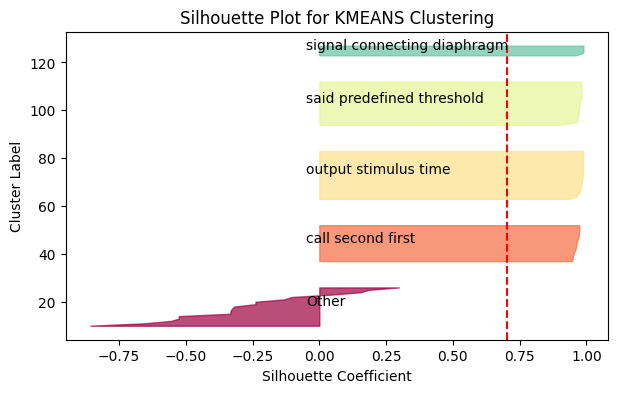

Silhouette Score: 0.7040249206740058


In [122]:
labels = df_['topic'].values
calc_silhouette_score(document_topic_matrix, labels, 'topic')

In [123]:
non_other_class = df_['topic'] != 'Other'
document_topic_matrix_non_other = document_topic_matrix[non_other_class]
document_topic_matrix_non_other.shape

(61, 5)

# Conclusion and improvements

## Winning Model - Why?

The selected model stands out for several reasons:

1. It is lighter than LDA or LLM models.
2. It includes a built-in mechanism to adapt to user requests for different numbers of clusters (k groups).
3. It consistently delivered the best and most stable silhouette scores.
4. It perform well on small datasets

## Improvements

* **Increase the dataset size**: Adding more claims to the dataset will expand the corpus and allow for more diverse groupings. Additionally, it will increase certainty by boosting the size of smaller groups.

* **Dimensionality reduction techniques**: Applying dimensionality reduction methods, such as PCA or t-SNE, will help visualize the possible clusters and assist in determining the appropriate number of clusters.

* **Use more holistic embedding techniques**: Similar to the third method, incorporating more advanced embeddings (beyond TF-IDF) could help uncover hidden connections within the data.

* **Utilize stronger/larger models**: A more robust model can provide more accurate results and handle complex challenges due to its ability to process larger input token sizes and multitask training. For instance, asking a model, "Based on the set of paragraphs, what different topics do you recognize?" could help address some of the clustering challenges.

## Other Possible Methods

* **Word2Vec techniques**: One possible method is to use a set of relevant words related to phone patent claims (e.g., "phone," "communication," "signal"). For each group, select the top K words and use this model again to embed the documents and apply a pooling technique. For each document embedding, calculate the distance (e.g., using cosine similarity) between the document and the selected word set. Assign the document to the group with the closest average distance. This method provides both clustering and topic generation.
